## Load the user connection data and connect to the SAP HANA database instance

Before running the next cell make sure [../0x00-setup/temp_user.ini](../0x00-setup/temp_user.ini) is copied to [../0x00-setup/user.ini](../0x00-setup/user.ini) and the user + password are set appropriately.

In [1]:
from hana_ml.algorithms.pal.utility import Settings
myhost, myport, myuser, mypwd = Settings.load_config("../0x00-setup/user.ini")

In [2]:
from hana_ml import dataframe as hdf
myconn=hdf.ConnectionContext(
    address=myhost, 
    port=myport, 
    user=myuser,
    password=mypwd
)
print(f"Connected to SAP HANA db version {myconn.hana_version()} \nat {myhost}:{myport} as user {myuser}")

Connected to SAP HANA db version 4.00.000.00.1689068747 (fa/CE2023.16) 
at b7c3ff95-9e0c-480d-9022-bfaaa268f780.hna0.prod-us10.hanacloud.ondemand.com:443 as user CodeJam00


In [3]:
print(myconn.sql("SELECT NOW() FROM DUMMY").collect().CURRENT_TIMESTAMP[0])

2023-07-20 16:43:49.870000


# Tables from SAP HANA

In [4]:
hdf_train=myconn.table('TRAIN', schema='TITANIC')

## The first look at the table

In [5]:
hdf_train.get_table_structure()

{'PassengerId': 'INT',
 'Survived': 'INT',
 'PClass': 'INT',
 'Name': 'NVARCHAR(5000)',
 'Gender': 'NVARCHAR(5000)',
 'Age': 'DOUBLE',
 'SibSp': 'INT',
 'ParCh': 'INT',
 'Ticket': 'NVARCHAR(5000)',
 'Fare': 'DOUBLE',
 'Cabin': 'NVARCHAR(5000)',
 'Embarked': 'NVARCHAR(5000)'}

Let's check various statistics of the dataset using [a `describe()` method](https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/hana_ml.dataframe.html#hana_ml.dataframe.DataFrame.describe)

In [6]:
hdf_train.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,PassengerId,891,891,0,446.000000,257.353842,1.00,891.0000,446.0000,223.5000,223.0000,446.0000,446.0000,668.5,669.0
1,Survived,891,2,0,0.383838,0.486592,0.00,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
2,PClass,891,3,0,2.308642,0.836071,1.00,3.0000,3.0000,2.0000,2.0000,3.0000,3.0000,3.0,3.0
3,Age,714,88,177,29.699118,14.526497,0.42,80.0000,28.0000,20.1250,20.0000,28.0000,28.0000,38.0,38.0
4,SibSp,891,7,0,0.523008,1.102743,0.00,8.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0,1.0
5,ParCh,891,7,0,0.381594,0.806057,0.00,6.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
6,Fare,891,248,0,32.204208,49.693429,0.00,512.3292,14.4542,7.9104,7.8958,14.4542,14.4542,31.0,31.0
7,Name,891,891,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Gender,891,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Ticket,891,681,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


🤓 **Let's discuss**:
- What can we read from the dataset above

# Unified Report

Unified Reports: https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/hana_ml.visualizers.html#module-hana_ml.visualizers.unified_report

In [7]:
from hana_ml.visualizers.unified_report import UnifiedReport

In [8]:
UnifiedReport(obj=hdf_train).build(key='PassengerId').display()

Generating dataset report...: 100%|███████████████████████████████████| 8/8 [00:49<00:00,  6.24s/it]
In order to review the dataset report better, you need to adjust the size of the left area or hide the left area temporarily!


🤓 **Let's discuss**:
1. What can be found in the dataset's report above

# EDA, or Exploratory Data Analysis

## Categorical variable evaluation: Passenger Class

In [9]:
from hana_ml.visualizers.eda import *

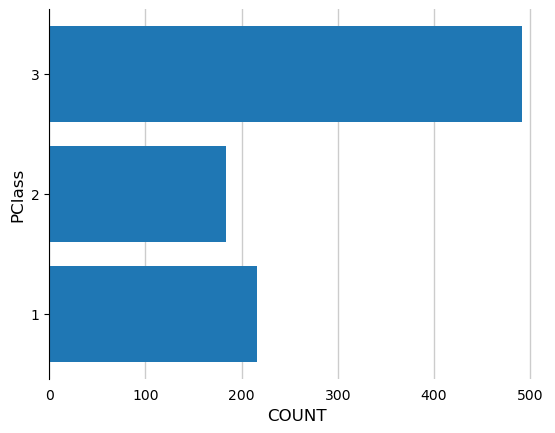

In [10]:
ax, bar_data = EDAVisualizer().bar_plot(data=hdf_train, column='PClass', aggregation={'PClass':'count'})

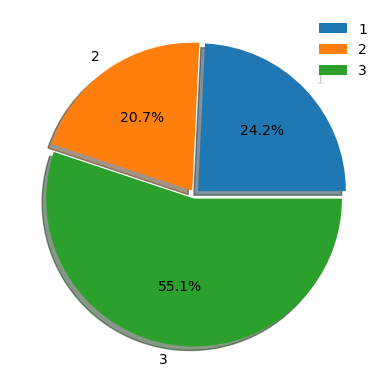

In [11]:
ax, pie_data = EDAVisualizer().pie_plot(data=hdf_train, column='PClass')

## Continuous variables evaluation: Age

TransformedBbox(
    Bbox(x0=0.0, y0=0.0, x1=14.0, y1=5.0),
    Affine2D().scale(100.0))


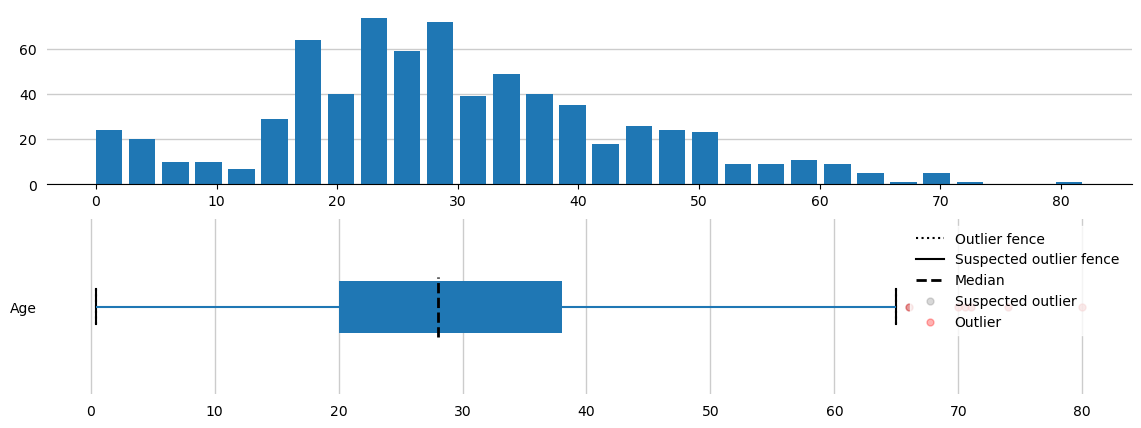

In [16]:
fig = plt.figure(figsize=(14,5))
#print (fig.figbbox)
ax1 = fig.add_subplot(211)
eda1 = EDAVisualizer(ax=ax1)
ax1, dist_data = eda1.distribution_plot(data=hdf_train.dropna(subset=['Age']), column="Age", bins=30)

ax2 = fig.add_subplot(212)
eda2 = EDAVisualizer(ax=ax2)
ax2, corr_data = eda2.box_plot(data=hdf_train.dropna(subset=['Age']), column='Age', outliers=True)
#plt.show()